**Brian Blaylock**  
**May 15, 2019**

# **Fig. 2.** Verification Domains and FSS radii

![](./figs/Fig-02_Domains.png)

> FIG. 2. The HRRR domain shaded by domain with west, central, and east subregion outlines used for model skill statistics. Each subregion has equal area—approximately 4,034,896 km2. Center circles represent radial footprints with radius of 30, 60, 120, and 240 km used in FSS calculations.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_HRRR.HRRR_Pando import get_hrrr_variable, pluck_hrrr_point
from BB_HRRR.HRRR_paths import get_domains
from BB_maps.my_basemap import draw_HRRR_map

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [5.5,5.5]
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 600    # 600 for print

In [4]:
def radial_footprint(radius):
    """A footprint with the given radius"""
    y,x = np.ogrid[-radius: radius+1, -radius: radius+1]
    footprint = x**2+y**2 <= radius**2
    footprint = 1*footprint.astype(float)
    return footprint

In [5]:
domains = get_domains()

HRRR Area in meters squared: 16811840278558.668
West Area in meters squared: 4034896806752.7593
Central Area in meters squared: 4034896806752.766
East Area in meters squared: 4034896806752.762


In [6]:
m = draw_HRRR_map(resolution='f')

loaded /uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_maps/saved_map_objects/HRRR_lcc_f_2000.npy map from file


In [7]:
H = get_hrrr_variable(datetime(2019,1,1), 'HGT:surface', verbose=False)
H_land = get_hrrr_variable(datetime(2019,1,1), 'LAND:surface', verbose=False)

# Set water points as a low value for terrain colormap to display correctly.
H['value'][H_land['value']==0] = -4500

In [8]:
# Make radius footprints
centerlon = -96
centerlat = 39

x, y = pluck_hrrr_point(H, centerlat, centerlon, XY_only=True)

#radii = [10, 20, 40, 80]
radii = [10, 40, 80]

mask = np.zeros_like(H['lat'])
for r in reversed(radii):
    footprint = radial_footprint(r)
    p, q = np.shape(footprint)
    mask[x-r:x-r+p, y-r:y-r+q] += footprint
    print('footprint size (km):', r*3)

 >> Requested Center lat: 39	 lon: -96
 >>     Plucked HRRR lat: 39.000503244838455	 lon: -96.01325243380218
 >>     Plucked from   x: 548	   y: 942
footprint size (km): 240
footprint size (km): 120
footprint size (km): 30


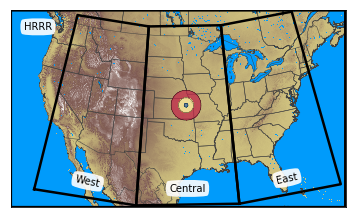

In [9]:
c = [.25,.25,.25]

for i, d in domains.items():
    xx = d['path'].vertices[:,0]
    yy = d['path'].vertices[:,1]
    X, Y = m(xx,yy)
    m.plot(X,Y, linewidth=2.5, color='k', linestyle='-')


m.drawcoastlines(linewidth=.5, color=c)
m.drawstates(linewidth=.5, color=c)
m.drawcountries(color=c)
m.pcolormesh(H['lon'], H['lat'], H['value'], vmin=-6100, vmax=4183, latlon=True, cmap='terrain');


#m.pcolormesh(H['lon'], H['lat'], np.ma.array(mask, mask=mask==0),
#             latlon=True, cmap='terrain', vmin=0.7, zorder=10)
m.contourf(H['lon'], H['lat'], np.ma.array(mask, mask=mask==0), latlon=True,
           cmap='Spectral', zorder=10, alpha=.75)
m.contour(H['lon'], H['lat'], mask, colors='k', linewidths=.4,
          latlon=True, zorder=10,
          levels=[0.000001,1,2,3,4,5,6])

# Add text labels for each domain
bbox = {'facecolor':'white',
        'alpha':0.90,
        'pad':.4,
        'edgecolor':'none',
        'boxstyle':'round4'}

i, j = m(-127.5, 47)
plt.text(i, j, 'HRRR', bbox=bbox, ha="center", va="center")

i, j = m(-112, 27)
plt.text(i, j, 'West', bbox=bbox, ha="center", va="center", rotation=-12)

i, j = m(-96, 27)
plt.text(i, j, 'Central', bbox=bbox, ha="center", va="center")

i, j = m(-80, 27)
plt.text(i, j, 'East', bbox=bbox, ha="center", va="center", rotation= 12)


plt.savefig('./figs/Fig-02_Domains')

In [10]:
for i, k in domains.items():
    print('%s area is %.3f km2' % (i, k['area']/1e6))

HRRR area is 16811840.279 km2
West area is 4034896.807 km2
Central area is 4034896.807 km2
East area is 4034896.807 km2


In [39]:
all_domains = get_domains(add_states=['UT','TX','CO'])

HRRR Area in meters squared: 16811840278558.668
West Area in meters squared: 4034896806752.7593
Central Area in meters squared: 4034896806752.766
East Area in meters squared: 4034896806752.762
Utah Area in meters squared: 219973261639.39685
Texas Area in meters squared: 688270731111.2987
Colorado Area in meters squared: 269906899003.7569


In [68]:
r10 = np.sum(radial_footprint(10))
r40 = np.sum(radial_footprint(40))
r80 = np.sum(radial_footprint(80))

print('{:<10} {:^12}{:^36}'.format('', '', 'rough number of completely unique neighborhoods(total grid/neighborhood size)'))
print('{:<10} {:^13}|{:^12}|{:^12}|{:^12}'.format('', '', 'r=30km', 'r=120km', 'r=240km'))
print('{:<10} |{:^12}| size={:<6.0f}| size={:<6.0f}| size={:<6.0f}'.format('Domain', 'Grid Points', r10, r40, r80))
print('----------------------------------------------------------')
for i, k in all_domains.items():
    grid_points = np.sum(np.invert(k['mask']))
    print('{:<10} |{:^12,}|{:^12.1f}|{:^12.1f}|{:^12.1f}'.format(i,
                                                                 grid_points,
                                                                 grid_points/r10,
                                                                 grid_points/r40,
                                                                 grid_points/r80))

                       rough number of completely unique neighborhoods(total grid/neighborhood size)
                        |   r=30km   |  r=120km   |  r=240km   
Domain     |Grid Points | size=317   | size=5025  | size=20081 
----------------------------------------------------------
HRRR       | 1,905,141  |   6009.9   |   379.1    |    94.9    
West       |  455,335   |   1436.4   |    90.6    |    22.7    
Central    |  455,335   |   1436.4   |    90.6    |    22.7    
East       |  455,331   |   1436.4   |    90.6    |    22.7    
Utah       |   24,406   |    77.0    |    4.9     |    1.2     
Texas      |   77,546   |   244.6    |    15.4    |    3.9     
Colorado   |   29,939   |    94.4    |    6.0     |    1.5     
